In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.plot import draw_raster_single

In [3]:
def plot_synthetic_data(K, L, sample_length, C, seed, mu, o1, o2, fs=1000, start=0):
    T = sample_length/fs
    trange = [0,T]
    data_path = f'saved/synthetic_data/simple_synthetic_gaussian_nodc_{K}_{L}_{sample_length}_{C}_{mu}_{o1}_{o2}_{seed}'
    c = 0

    data_load = pickle_open(data_path)

    Gamma = data_load['latent']['Gamma']
    xs = data_load['latent']['xs']
    vs = data_load['latent']['vs']
    zs = data_load['latent']['zs']
    ys = data_load['observed']['ys']

    freqs = data_load['meta']['freqs']

    swap = False
    ls = [0,1,2]
    fig,ax = plt.subplots(4,1,figsize=(10,5), sharex=True)
    ls = [l + start for l in ls]
    title_size = 16
    label_size = 14
    x = np.arange(0, sample_length) / 1000
    # for i in range(start,start+3):
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for i, l in enumerate(ls):
    # i = 3
        
        ax[0].plot(x, xs[l,0,:], color=colors[i])
        # ax[0].set_ylim([-1,1])
        ax[0].margins(0)
        ax[0].set_title(r'$x_t^{1, \ell}$  $\ell = (1,2,3)$', size=title_size)
        ax[0].set_ylabel('mV', size = label_size)

        ax[1].plot(x, xs[l,1,:], color=colors[i])
        # ax[1].set_ylim([-1,1])
        ax[1].margins(0)
        ax[1].set_title(r'$x_t^{2, \ell}$  $\ell = (1,2,3)$', size=title_size)
        ax[1].set_ylabel('mV', size = label_size)

        ax[2].plot(x, ys[l,c,0,:], color=colors[i])
        ax[2].set_title(r'$y_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
        ax[2].margins(0)
        ax[2].set_ylabel('mV', size = label_size)

        ax[3].plot(x, ys[l,c,1,:], color=colors[i])
        ax[3].set_title(r'$y_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
        ax[3].margins(0)
        ax[3].set_ylabel('mV', size = label_size)

    # draw_raster_single(spikes[start,:,:], trange=[0,0.5], region='CPB', override_bg_color='white',ax=ax[3])

    ax[3].set_xlabel('Time (sec)', size = label_size)
    plt.xlim([0,sample_length/fs])
    plt.tight_layout()

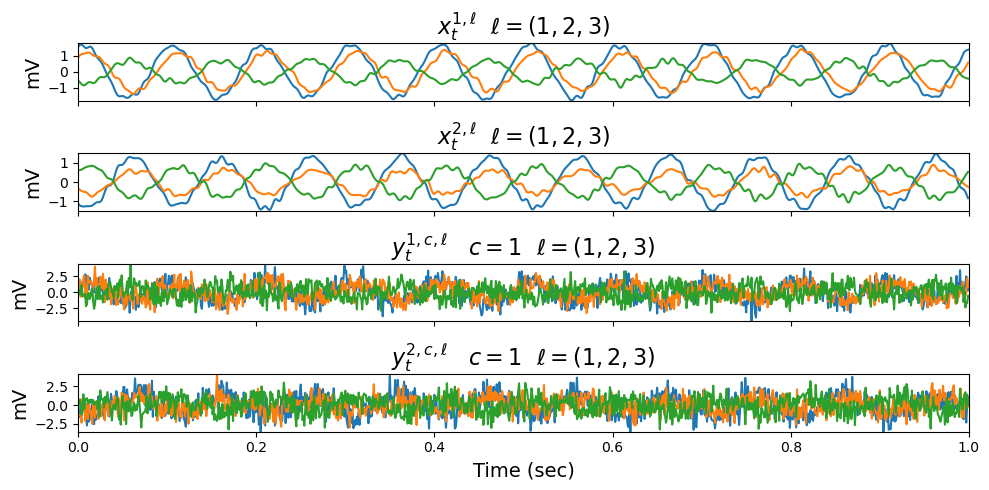

In [4]:
# mu = -1.0
mu = 0.0
K = 2
L = 25 
C = 1
sample_length = 1000
seed = 7
o1 = 1.0
o2 = 0.0
plot_synthetic_data(K, L, sample_length, C, seed, mu, o1, o2, start=3)



In [43]:
o1 = 1.0
o2 = 0.0
# data_path = f'saved/synthetic_data/simple_synthetic_gaussian_{K}_{L}_{sample_length}_{C}_{mu}_{o1}_{o2}_{seed}'
data_path = f'saved/synthetic_data/simple_synthetic_gaussian_nodc_{K}_{L}_{sample_length}_1_0.0_1.0_0.0_7'
seed = 8
model_path = f'saved/fitted_models/simple_synthetic_gaussian_em10_{K}_{L}_{sample_length}_{C}_{mu}_{o1}_{o2}_{seed}_fitted_analytical'

data_load = pickle_open(data_path)
model_load = pickle_open(model_path)
Gamma = data_load['latent']['Gamma']
Gamma_true = Gamma
zs = data_load['latent']['zs']
vs = data_load['latent']['vs']
xs = data_load['latent']['xs']
ys_avg = model_load['ys_Cavg']
# ys = data_load['observed']['ys']

freqs = data_load['meta']['freqs']

Wv_model = model_load['Wv']
Wv = Wv_model
num_J_vars = Wv.shape[1]
freqs_mod = freqs[:int((Wv.shape[1]) / 2)]

J_max = int((Wv.shape[1])/2)


In [44]:
# let's try covariance estimation with jax
from functools import partial
import jax.numpy as jnp

zs_short = jnp.array(zs[:,:,:49])


In [45]:
evens = np.arange(Wv.shape[1]) % 2 == 0
W = Wv[:,evens] - 1j*Wv[:,~evens]

In [46]:
xv = Wv @ vs[0,0,:98]

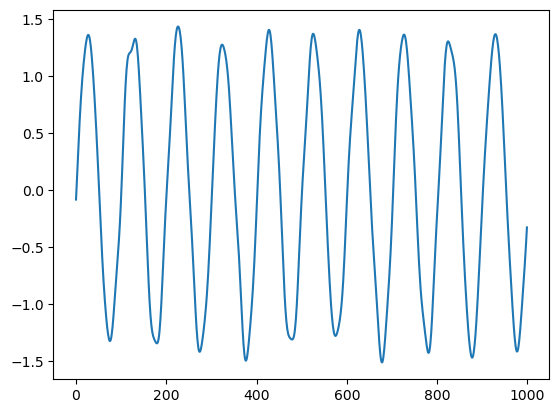

In [47]:
plt.plot(xv)

In [48]:
l = 0
k = 0 

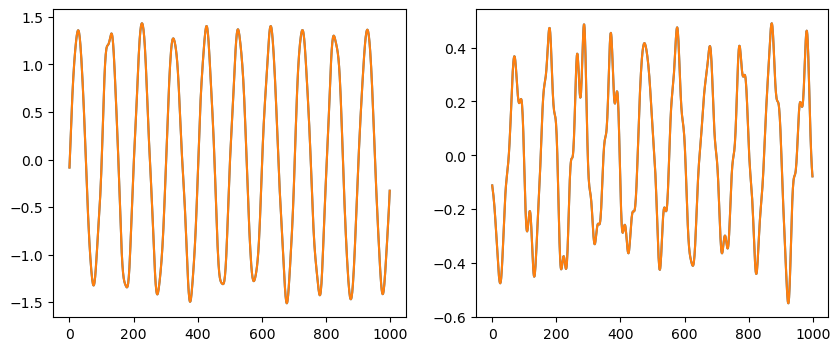

In [49]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
for k in range(2):
    xv = Wv @ vs[0,k,:98]
    xz = W @ zs[0,k,:49]
    ax[k].plot(xv)
    ax[k].plot(xz.real)

In [50]:
model_load['ys_Cavg'].shape

(25, 2, 1000)

### Let's try single-frequency model 

In [51]:
import jax.numpy as jnp
def get_cost_func(trial_data, W, Gamma_prev_inv, fs=1e3):
    K = len(trial_data)
    J = W.shape[1]
    C = 1
    delta = 1/fs

    def obs_cost_k(data_k, z_k):
        x = (W @ z_k).real

        resid = data_k - x

        obs_cost = -(1/2)* (resid.T @ Q_inv @ resid)

        return obs_cost

    def cost_func(z):
        obs_terms = jnp.array([obs_cost_k(trial_data[k], z[k*J:k*J+J]) for k in range(K)]).sum()
        prior_term = z.conj().T @ Gamma_prev_inv @ z

        cost = obs_terms - prior_term

        return -cost[0]
    return cost_func




In [52]:
trial_data = [model_load['ys_Cavg'][:,k,:] for k in range(K)]

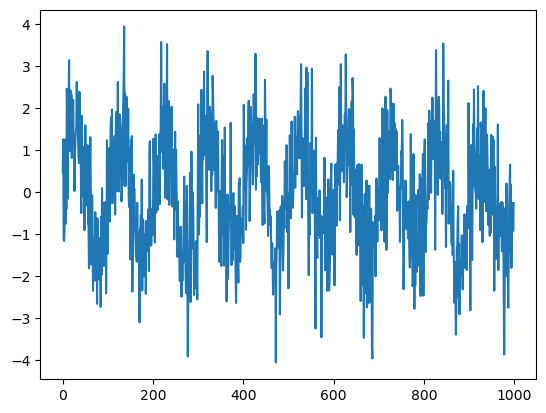

In [53]:
for l in range(1):
    plt.plot(trial_data[0][l,:])

In [54]:
# Gamma_init = jnp.stack([jnp.eye(K, dtype=complex) for _ in range(49)])
# jnpW = jnp.array(W)
# jnp_trial_data = jnp.stack(trial_data)

# test = get_cost_func(trial_data, jnpW, Gamma_init)

In [19]:
def ll_ccn(Gamma_vec, zs):
    L = zs.shape[0]
    K = zs.shape[1]
    J = zs.shape[2]
    Gamma = Gamma_vec.reshape(J,K,K)
    Gamma_inv = jnp.stack([jnp.linalg.inv(Gamma[j,:,:]) for j in range(J)])
    termA = L*jnp.log(jnp.linalg.det(Gamma).real).sum()
    termB = jnp.einsum('lkj,jki,lkj->lj', zs.conj(), Gamma_inv, zs).real.sum()
    log_likelihood = -(1/2)*(termA + termB)
    return -log_likelihood

In [1]:
J = 2
Gamma_init = jnp.stack([jnp.eye(K).astype(complex) for _ in range(50)])
Gamma_init_vec = Gamma_init.flatten()

NameError: name 'jnp' is not defined

In [21]:
np.argmax((zs_short*zs_short.conj()).mean(0).real)

Array(9, dtype=int32)

In [22]:
1

1

In [23]:
Wv.shape

(1000, 98)

In [24]:
import jax.scipy.optimize as jop
# from jax import grad, hessian
# import scipy.optimize as op
cost_func = partial(ll_ccn, zs=zs_short[:,:,8:10])
Gamma_init = jnp.stack([jnp.eye(K).astype(complex) for _ in range(2)])
Gamma_init_vec = Gamma_init.flatten()
Result = jop.minimize(fun=cost_func, x0=Gamma_init_vec, method='BFGS', options={'maxiter':100})

In [25]:
J = 2
Gamma_est = Result.x.reshape(J,K,K)

In [26]:
Gamma_direct = np.einsum('lkj,lmj->lkmj', zs_short.conj(), zs_short).mean(0).swapaxes(2,1).swapaxes(0,1)

In [27]:
j = 2
Gamma_est[j,:,:]
Gamma_est_vec = Gamma_est.flatten()
test = Gamma_est_vec.reshape(J,K,K)

In [29]:
Gamma_est.shape

(2, 2, 2)

In [30]:
# plt.plot(Gamma_true[:50,0,0].real)
# plt.plot(Gamma_est[:,0,0].real)
# # plt.plot(Gamma_direct[:50,0,0].real)

In [31]:
r = 5
track_r = model_load['track'][0][r]
mus = track_r['mus']
Ups_invs = track_r['Ups_invs']

In [32]:
from functools import partial
import jax.numpy as jnp
import jax.random as jr
rk = jr.key(7)
Gamma_init = jnp.zeros_like(Gamma_true[:50,:,:])

In [33]:

jnp_mus = jnp.array(mus)
jnp_Ups_invs = jnp.array(Ups_invs)

k = 0
test = jnp_mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]


In [34]:
test.shape

(25, 98)

In [35]:
from functools import partial:
import jax.numpy as jnp
def m_step_cost_func_large(Gamma, mus, Ups_invs, K, num_J_vars):
    for k in range(K):
        mu_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
        Ups_invs_k = Ups_invs[]

def update_Gamma_real_jax(mus, Ups_invs, K, num_J_vars):


SyntaxError: invalid syntax (4122411740.py, line 1)